# Training with two losses (reco+class) generally leads to worse performance than pretrain, fix weights and train classifier

In [1]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
        self.classifier = self._create_classifier(latent_dim)
        self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_reco  = self.decode(z ,training=training)
        y_class = self.classify(z, training=training)
        return {'decoder_out': y_reco, 'classifier_out': y_class}
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim)
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * n_filters[0]),  # factor 4 due to conv.
            Reshape((io_shape[0]//4, io_shape[1]//4, n_filters[0])),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(10, name='classfier_out', activation='softmax')
        ])

1-split, verify performance for classifier loss weight=0

In [2]:
import keras
import numpy as np

n_splits = 1
io_shape = (28,28,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16

model = MultiSplit(n_splits, latent_dim, io_shape)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, size, size) for x in x_train], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, size, size) for x in x_test], dtype='float32')
y_test = keras.utils.to_categorical(y_test)
print(x_test_split.shape)

(10000, 1, 28, 28, 1)


Epoch 1/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0218 - classifier_out_loss: 3.8209 - decoder_out_loss: 0.0218 - classifier_out_accuracy: 0.0876 - decoder_out_accuracy: 0.8104 - val_loss: 0.0109 - val_classifier_out_loss: 3.6948 - val_decoder_out_loss: 0.0109 - val_classifier_out_accuracy: 0.0776 - val_decoder_out_accuracy: 0.8122
Epoch 2/25
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0102 - classifier_out_loss: 3.5082 - decoder_out_loss: 0.0102 - classifier_out_accuracy: 0.0796 - decoder_out_accuracy: 0.8135 - val_loss: 0.0093 - val_classifier_out_loss: 3.4150 - val_decoder_out_loss: 0.0093 - val_classifier_out_accuracy: 0.0746 - val_decoder_out_accuracy: 0.8127
Epoch 3/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0091 - classifier_out_loss: 3.2885 - decoder_out_loss: 0.0091 - classifier_out_accuracy: 0.0787 - decoder_out_accuracy: 0.8139 - val_loss: 0.0086 - val_classifier_out_loss: 3.1957 - val_decoder_o

<ipython-input-3-0196e6808182>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


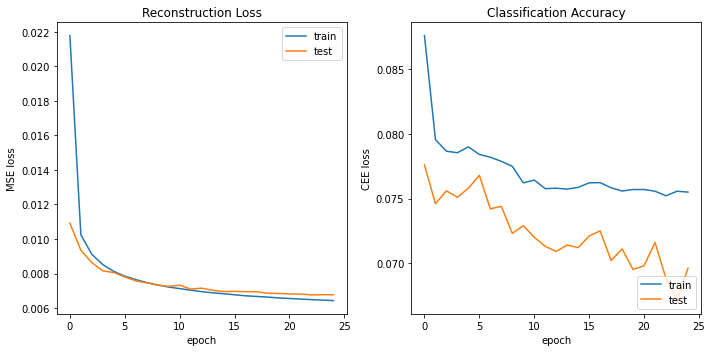

In [3]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy'
}
loss_weights = {
    'decoder_out' : 1.0,
    'classifier_out' : 0.0
}
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train_split, {'decoder_out': x_train, 'classifier_out': y_train},
                    validation_data=(x_test_split, {'decoder_out': x_test, 'classifier_out': y_test}),
                    epochs=25, batch_size=32)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title('Reconstruction Loss')
axes[0].plot(history.history['decoder_out_loss'])
axes[0].plot(history.history['val_decoder_out_loss'])
axes[0].set_ylabel('MSE loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'test'], loc='upper right')

axes[1].set_title('Classification Accuracy')
axes[1].plot(history.history['classifier_out_accuracy'])
axes[1].plot(history.history['val_classifier_out_accuracy'])
axes[1].set_ylabel('CEE loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'test'], loc='lower right')

fig.tight_layout()
fig.show()
fig.savefig('../img/21/CE16_reco1_classify0.png')

4-split, verify performance for classifier loss weight=0

In [5]:
import keras
import numpy as np

n_splits = 4
io_shape = (28,28,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16

model = MultiSplit(n_splits, latent_dim, io_shape)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, size, size) for x in x_train], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, size, size) for x in x_test], dtype='float32')
y_test = keras.utils.to_categorical(y_test)
print(x_test_split.shape)

(10000, 4, 14, 14, 1)


Epoch 1/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0240 - classifier_out_loss: 3.1905 - decoder_out_loss: 0.0240 - classifier_out_accuracy: 0.1492 - decoder_out_accuracy: 0.8090 - val_loss: 0.0143 - val_classifier_out_loss: 3.0793 - val_decoder_out_loss: 0.0143 - val_classifier_out_accuracy: 0.1632 - val_decoder_out_accuracy: 0.8114
Epoch 2/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0133 - classifier_out_loss: 2.9198 - decoder_out_loss: 0.0133 - classifier_out_accuracy: 0.1650 - decoder_out_accuracy: 0.8123 - val_loss: 0.0123 - val_classifier_out_loss: 2.8023 - val_decoder_out_loss: 0.0123 - val_classifier_out_accuracy: 0.1738 - val_decoder_out_accuracy: 0.8117
Epoch 3/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0121 - classifier_out_loss: 2.7352 - decoder_out_loss: 0.0121 - classifier_out_accuracy: 0.1704 - decoder_out_accuracy: 0.8128 - val_loss: 0.0115 - val_classifier_out_loss: 2.6952 - val_decoder_ou

<ipython-input-6-440db8ff8ebb>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


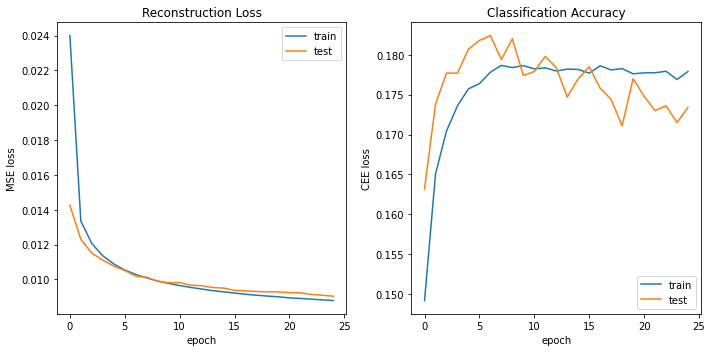

In [6]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy'
}
loss_weights = {
    'decoder_out' : 1.0,
    'classifier_out' : 0.0
}
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train_split, {'decoder_out': x_train, 'classifier_out': y_train},
                    validation_data=(x_test_split, {'decoder_out': x_test, 'classifier_out': y_test}),
                    epochs=25, batch_size=32)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title('Reconstruction Loss')
axes[0].plot(history.history['decoder_out_loss'])
axes[0].plot(history.history['val_decoder_out_loss'])
axes[0].set_ylabel('MSE loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'test'], loc='upper right')

axes[1].set_title('Classification Accuracy')
axes[1].plot(history.history['classifier_out_accuracy'])
axes[1].plot(history.history['val_classifier_out_accuracy'])
axes[1].set_ylabel('CEE loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'test'], loc='lower right')

fig.tight_layout()
fig.show()
fig.savefig('../img/21/CE4x4_reco1_classify0.png')